In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

In [163]:
# Define Bezier curve function for cubic case
def cubic_bezier(P0, P1, P2, P3, t):
    """Evaluate the cubic Bezier curve at parameter t"""
    return (1 - t)**3 * P0 + 3 * (1 - t)**2 * t * P1 + 3 * (1 - t) * t**2 * P2 + t**3 * P3

# Define derivative of cubic Bezier curve
def cubic_bezier_derivative(P0, P1, P2, P3, t):
    """Evaluate the derivative of the cubic Bezier curve at parameter t"""
    return 3 * (1 - t)**2 * (P1 - P0) + 6 * (1 - t) * t * (P2 - P1) + 3 * t**2 * (P3 - P2)

# Define 2nd and 3rd derivatives of cubic Bezier curve
def cubic_bezier_2nd_derivative(P0, P1, P2, P3, t):
    """Evaluate the 2nd derivative of the cubic Bezier curve at parameter t"""
    return 6 * (1 - t) * (P2 - 2 * P1 + P0) + 6 * t * (P3 - 2 * P2 + P1)

def cubic_bezier_3rd_derivative(P0, P1, P2, P3):
    """Evaluate the 3rd derivative of the cubic Bezier curve at parameter t"""
    return 6 * (P3 - 3 * P2 + 3 * P1 - P0)

def qabc_from_accel(accel, gravity=9.81):
    """
    Computes the quaternion qabc from the given acceleration and gravity values using the Hopf Fibration.
    
    Parameters:
    accel (array-like): The 3D acceleration vector [ax, ay, az].
    gravity (float): The gravity constant, default is +9.81.
    
    Returns:
    qabc (numpy array): The computed quaternion [q0, q1, q2, q3] with norm=1.
    """
    ax, ay, az = accel

    # Calculate thrust vector
    thrust = np.array([ax, ay, az + gravity])
    
    # Normalize the thrust vector
    thrust_normalized = thrust / np.linalg.norm(thrust)
    
    a = thrust_normalized[0]
    b = thrust_normalized[1]
    c = thrust_normalized[2]
    
    # Calculate quaternion qabc (ensuring norm=1)
    qabc = (1 / np.sqrt(2 * (1 + c))) * np.array([1 + c, -b, a, 0])

    return qabc

# Hopf fibration to get quaternion from acceleration and yaw
def hopf_fibration(acceleration, yaw):
    """Use the Hopf fibration to compute the quaternion representing the attitude."""
    # norm_accel = np.linalg.norm(acceleration)
    # if norm_accel > 0:
    #     accel_normalized = acceleration / norm_accel
    # else:
    #     accel_normalized = np.array([0, 0, 1])  # Default to pointing upwards if no acceleration
    
    # Quaternion from yaw
    q_yaw = np.array([np.cos(yaw / 2), 0, 0, np.sin(yaw / 2)])
    
    # Quaternion from acceleration (z-axis aligned with acceleration)
    q_abc = qabc_from_accel(acceleration)
    
    # Multiply quaternions to get the combined orientation
    return quaternion_multiply(q_abc, q_yaw)

# Quaternion multiplication
def quaternion_multiply(q1, q2):
    """Multiply two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2 
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2 
    return np.array([w, x, y, z])

# Get the attitude vectors
def get_attitude_vector(obstacle_position, pos, acceleration, yaw):

    quaternion = hopf_fibration(acceleration, yaw)

    # Compute the desired attitude vector (from the agent to the obstacle)
    tracking_vector = obstacle_position - pos
    desired_attitude_vector = tracking_vector / np.linalg.norm(tracking_vector)

    # Get rotation matrix from quaternion
    R = np.array([
        [1 - 2 * quaternion[2]**2 - 2 * quaternion[3]**2, 2 * quaternion[1] * quaternion[2] - 2 * quaternion[0] * quaternion[3], 2 * quaternion[1] * quaternion[3] + 2 * quaternion[0] * quaternion[2]],
        [2 * quaternion[1] * quaternion[2] + 2 * quaternion[0] * quaternion[3], 1 - 2 * quaternion[1]**2 - 2 * quaternion[3]**2, 2 * quaternion[2] * quaternion[3] - 2 * quaternion[0] * quaternion[1]],
        [2 * quaternion[1] * quaternion[3] - 2 * quaternion[0] * quaternion[2], 2 * quaternion[2] * quaternion[3] + 2 * quaternion[0] * quaternion[1], 1 - 2 * quaternion[1]**2 - 2 * quaternion[2]**2]
    ])

    # Get heading vector
    attitude_vector = R[:, 0]
    attitude_vector /= np.linalg.norm(attitude_vector)

    return desired_attitude_vector, attitude_vector

In [207]:
class CustomBSpline:
    def __init__(self, control_points, knots, degree):
        """
        Initialize a B-spline curve.
        
        Parameters:
        control_points (ndarray): Control points (n x d) where n is the number of points and d is the dimension.
        knots (ndarray): Knot vector.
        degree (int): Degree of the B-spline curve.
        """
        self.control_points = np.array(control_points)
        self.knots = np.array(knots)
        self.degree = degree
        self.n_control_points = np.shape(control_points)[0]
        
    def basis_function(self, i, k, t):
        """
        Cox-de Boor recursion formula to compute B-spline basis function.
        
        Parameters:
        i (int): Index of the control point.
        k (int): Degree of the basis function.
        t (float): Parameter value.
        
        Returns:
        float: Value of the basis function at t.
        """

        if k == 0:
            if self.knots[i] <= t < self.knots[i + 1]:
                return 1.0
            return 0.0
        else:
            denom1 = self.knots[i + k] - self.knots[i]
            denom2 = self.knots[i + k + 1] - self.knots[i + 1]
            
            term1 = (t - self.knots[i]) / denom1 * self.basis_function(i, k - 1, t) if denom1 != 0 else 0
            term2 = (self.knots[i + k + 1] - t) / denom2 * self.basis_function(i + 1, k - 1, t) if denom2 != 0 else 0
            
            return term1 + term2
        
    def eval(self, t):
        """
        Evaluate the B-spline curve at a given parameter value.
        
        Parameters:
        t (float): Parameter value.
        
        Returns:
        ndarray: The point on the B-spline curve at parameter t.
        """

        

        if t <= self.knots[0]:
            return self.control_points[0]
        if t >= self.knots[-1]:
            return self.control_points[-1]

        result = np.zeros_like(self.control_points[0])
        for i in range(self.n_control_points):
            result += self.basis_function(i, self.degree, t) * self.control_points[i]
        return result
    
    def derivative(self, t, order=1):
        """
        Compute the derivative of the B-spline curve at a given parameter value.
        
        Parameters:
        t (float): Parameter value.
        order (int): Order of the derivative (1 for velocity, 2 for acceleration, etc.)
        
        Returns:
        ndarray: The derivative of the curve at parameter t.
        """
        if order == 0:
            return self.eval(t)
        
        result = np.zeros_like(self.control_points[0])
        for i in range(self.n_control_points - order):
            coeff = self.degree / (self.knots[i + self.degree + 1] - self.knots[i + order])
            if coeff != 0:
                result += coeff * (self.control_points[i + 1] - self.control_points[i]) * self.basis_function(i, self.degree - 1, t)
        
        return result
    
    def velocity(self, t):
        """Compute the velocity at a given time."""
        return self.derivative(t, order=1)
    
    def acceleration(self, t):
        """Compute the acceleration at a given time."""
        return self.derivative(t, order=2)
    
    def jerk(self, t):
        """Compute the jerk at a given time."""
        return self.derivative(t, order=3)


In [266]:
def get_bspline_3d(pos_control_points, yaw_control_points, pos_knots, yaw_knots, degree, obstacle_position, label='B-spline Curve', use_optimized_curve=True):
    
    # Number of samples
    plot_samples = 100

    # Create the B-spline in each dimension (x, y, z)
    pos_trajectory = CustomBSpline(pos_control_points, pos_knots, degree)

    # Create the B-spline for yaw
    yaw_trajectory = CustomBSpline(yaw_control_points, yaw_knots, degree)

    # Generate points to evaluate the B-spline on
    t_values = np.linspace(pos_knots[0], pos_knots[-1], plot_samples)

    # Evaluate atitude vectors
    quivers = []
    x_values = []
    y_values = []
    z_values = []

    for t in range(0, plot_samples):
        pos_at_t = pos_trajectory.eval(t_values[t])
        x_values.append(pos_at_t[0])
        y_values.append(pos_at_t[1])
        z_values.append(pos_at_t[2])

    for t in range(0, plot_samples, 10):
        pos_at_t = pos_trajectory.eval(t_values[t])
        if use_optimized_curve:
            # Compute attitude vector using hopf fibration
            accel_at_t = pos_trajectory.acceleration(t_values[t])
            yaw_at_t = yaw_trajectory.eval(t_values[t])
            _, attitude_vector = get_attitude_vector(obstacle_position, pos_at_t, accel_at_t, yaw_at_t)
        else:
            # Just use the tracking vector
            attitude_vector = obstacle_position - pos_at_t
            attitude_vector /= np.linalg.norm(attitude_vector)

        quiver = np.array([pos_at_t, attitude_vector])
        quivers.append(quiver)

    return x_values, y_values, z_values, quivers

In [290]:
# Define constants
p = 3 # degree of bspline
num_segments = 4 # number of intervals ( = num_control_points - p + 1)
m_pos = num_segments + 2 * p # number of knots for position
m_yaw = num_segments + 2 * p # number of knots for yaw
n_pos = m_pos - p - 1 # (n_pos + 1) is the number of control points for position
n_yaw = m_yaw - p - 1 # (n_yaw + 1) is the number of control points for yaw
obstacle_position = np.array([2.5, 0.5, 0.0])  # Obstacle position in 3D
t_final = 1.0  # Final time
n_samples = 8  # Number of points to sample along the trajectory

# Define the start and end positions for the trajectory in 3D
start_position = np.array([0, 0, 0])  # Initial position in 3D
end_position = np.array([5, 0, 0])    # Final position in 3D

# Dynamically generate the initial straight-line trajectory control points in 3D
interval_initial_pos_control_points = np.linspace(start_position, end_position, n_pos + 1 - 3 - 2) # 3 is the number of control points for the initial state, 2 is the number of control points for the final state

# Initial yaw control points (1D yaw)
internal_initial_yaw_control_points = np.zeros((n_yaw + 1 - 3 - 2)) # 3 is the number of control points for the initial state, 2 is the number of control points for the final state

# Desired first and last states for position in 3D
p0 = np.array([0.0, 0.0, 0.0])  # Initial position in 3D
v0 = np.array([0.0, 0.0, 0.0])  # Initial velocity in 3D
a0 = np.array([0.0, 0.0, 0.0])  # Initial acceleration in 3D
pf = np.array([5.0, 0.0, 0.0])   # Final position in 3D
vf = np.array([0.0, 0.0, 0.0])   # Final velocity in 3D
af = np.array([0.0, 0.0, 0.0])   # Final acceleration in 3D
yaw_0 = 0.0  # Initial yaw
yaw_vel_0 = 0.0  # Initial yaw velocity
yaw_accel_0 = 0.0  # Initial yaw acceleration
yaw_vel_f = 0.0  # Final yaw velocity
yaw_accel_f = 0.0  # Final yaw acceleration

# Initialize the clamped uniform knots for position and yaw
# Clamped uniform knots could give us an error: The spline has internal repeated knots and is not differentiable 1 times
# So we need to the clamped part as well as the corresponding control points
clamped_knots_pos = np.concatenate(([0] * (p), np.linspace(0, t_final, m_pos - 2 * (p + 1) + 3), [t_final] * (p)))
clamped_knots_yaw = np.concatenate(([0] * (p), np.linspace(0, t_final, m_yaw - 2 * (p + 1) + 3), [t_final] * (p)))

# Calculate q0, q1, q2 based on the p0, v0, a0
q0 = p0
q1 = p0 + (-clamped_knots_pos[1] + clamped_knots_pos[p+1]) * v0 / p
q2 = (p * p * q1 - (clamped_knots_pos[1+p+1] - clamped_knots_pos[2]) * (a0 * (clamped_knots_pos[2] - clamped_knots_pos[p+1]) + v0) - p * (q1 + (-clamped_knots_pos[1+p+1] + clamped_knots_pos[2]) * v0)) / ((-1 + p) * p)

# calculate yaw_q0, yaw_q1, yaw_q2 based on the yaw_0, yaw_vel_0, yaw_accel_0
yaw_q0 = yaw_0
yaw_q1 = yaw_0 + (-clamped_knots_yaw[1] + clamped_knots_yaw[p+1]) * yaw_vel_0 / p
yaw_q2 = (p * p * yaw_q1 - (clamped_knots_yaw[1+p+1] - clamped_knots_yaw[2]) * (yaw_accel_0 * (clamped_knots_yaw[2] - clamped_knots_yaw[p+1]) + yaw_vel_0) - p * (yaw_q1 + (-clamped_knots_yaw[1+p+1] + clamped_knots_yaw[2]) * yaw_vel_0)) / ((-1 + p) * p)

# Get clamped control points and knots
clamped_initial_pos_control_points = np.vstack((q0, q1, q2, interval_initial_pos_control_points, interval_initial_pos_control_points[-1], interval_initial_pos_control_points[-1]))
clamped_initial_yaw_control_points = np.hstack((yaw_q0, yaw_q1, yaw_q2, internal_initial_yaw_control_points, internal_initial_yaw_control_points[-1], internal_initial_yaw_control_points[-1]))
initial_pos_trajectory = CustomBSpline(clamped_initial_pos_control_points, clamped_knots_pos, p)
initial_yaw_trajectory = CustomBSpline(clamped_initial_yaw_control_points, clamped_knots_yaw, p)

# Objective function to minimize
def objective(x):

    pos_control_points = x[:(n_pos + 1) * 3].reshape((n_pos + 1), 3)
    yaw_control_points = x[(n_pos + 1) * 3:]

    # Evaluate the B-spline for position and yaw at sampled time points
    pos_trajectory = CustomBSpline(pos_control_points, clamped_knots_pos, p)
    yaw_trajectory = CustomBSpline(yaw_control_points, clamped_knots_yaw, p)

    # Sampling based costs (position and yaw tracking)
    J_pos = 0
    J_tracking = 0
    for t in np.linspace(0, t_final, n_samples):
        pos_at_t = pos_trajectory.eval(t)
        accel_at_t = pos_trajectory.acceleration(t)
        yaw_at_t = yaw_trajectory.eval(t)

        # 1. Position trajectory cost (minimizing deviation from initial control points)
        J_pos += np.linalg.norm(pos_at_t - initial_pos_trajectory.eval(t))**2

        # 2. Yaw tracking cost (yaw should point towards the obstacle)
        desired_attitude_vector, attitude_vector = get_attitude_vector(obstacle_position, pos_at_t, accel_at_t, yaw_at_t)
        J_tracking += (1 - np.dot(attitude_vector, desired_attitude_vector))**2  # Maximize alignment (dot product)

    # Smoothness cost
    J_pos_smoothness = np.linalg.norm(pos_trajectory.jerk(0)**2)     # jerk is constant so it doesn't matter where we evaluate it - we can evaluate it at 0
    J_yaw_smoothness = np.linalg.norm(yaw_trajectory.jerk(0)**2)     # jerk is constant so it doesn't matter where we evaluate it - we can evaluate it at 0



    # Review these initial and final state costs!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



    # Initial and final state cost
    # p0, v0, and a0 determines the first three control points
    J_initial_state = np.linalg.norm(pos_trajectory.eval(0) - q2)**2
    # p3, v3, and a3 determines the last three control points
    J_final_state = np.linalg.norm(pos_trajectory.eval(t_final) - pf)**2
    # Initial yaw cost
    J_initial_yaw = (yaw_trajectory.eval(0) - yaw_0)**2
    # Final yaw cost
    # J_final_yaw = (yaw_trajectory.velocity(t_final) - yaw_vel_f)**2

    # Total objective
    return 30.0 * J_pos + 100.0 * J_tracking + 10.0 * J_pos_smoothness + 1000.0 * J_yaw_smoothness + 100.0 * J_initial_state + 100.0 * J_final_state + 100.0 * J_initial_yaw

# Hard constraints for the first and last state
# def constraint_first_position(x):
#     pos_control_points = x[:(n_pos + 1) * 3].reshape((n_pos + 1), 3)
#     return pos_control_points[0] - p0

# def constraint_last_position(x):
#     pos_control_points = x[:(n_pos + 1) * 3].reshape((n_pos + 1), 3)
#     return pos_control_points[-1] - desired_last_position

# def constraint_first_yaw(x):
#     yaw_control_points = x[(n_yaw + 1) * 3:]
#     return yaw_control_points[0] - yaw_0

# # Define the constraints
# constraints = [
#     {'type': 'eq', 'fun': constraint_first_position},
#     {'type': 'eq', 'fun': constraint_last_position},
#     {'type': 'eq', 'fun': constraint_first_yaw},
# ]

# Initial guess: concatenate position and yaw control points
# Remove the first three control points for position and yaw
x0 = np.hstack((clamped_initial_pos_control_points.flatten(), clamped_initial_yaw_control_points))

# Algorithms
algorithms = ["Nelder-Mead", "Powell", "CG", "BFGS", "L-BFGS-B", "TNC", "COBYQA", "SLSQP"]
algorithms = ["SLSQP"]

for algo in algorithms:

    # Measure computational time
    start = time.time()

    # Minimize using SciPy's minimize function
    # res = minimize(objective, x0, method=algo, constraints=constraints) # hard constraints
    res = minimize(objective, x0, method=algo) # soft constraints

    # Extract optimized control points
    clamped_optimized_pos_control_points = res.x[:(n_pos + 1) * 3].reshape(((n_pos + 1), 3))
    clamped_optimized_yaw_control_points = res.x[(n_pos + 1) * 3:]

    # Output result
    print("***", algo, "***")
    print("Time taken: ", time.time() - start)
    print("Cost", res.fun)
    print("Optimized Position Control Points (3D):")
    print(clamped_optimized_pos_control_points)
    print("Optimized Yaw Control Points (1D):")
    print(clamped_optimized_yaw_control_points)

*** SLSQP ***
Time taken:  5.504273891448975
Cost 47.586664979945205
Optimized Position Control Points (3D):
[[-7.92044121e-04  1.20855069e-03 -3.89576216e-03]
 [ 4.16618959e-02 -4.68216775e-02  3.16446953e-01]
 [ 4.15766395e-02 -4.52684956e-02  3.18218085e-01]
 [ 2.77206892e-01 -7.37639903e-02 -1.86949505e-01]
 [ 4.95037648e+00  7.20440125e-02  3.71694731e-01]
 [ 4.54771741e+00 -4.54255316e-01  9.35170766e-02]
 [ 5.00501745e+00  3.97531687e-03 -2.91252476e-03]]
Optimized Yaw Control Points (1D):
[2.48755912e-03 4.34792857e-01 4.34809999e-01 4.65065556e-02
 3.15136886e+00 3.16060514e+00 2.76808912e+00]


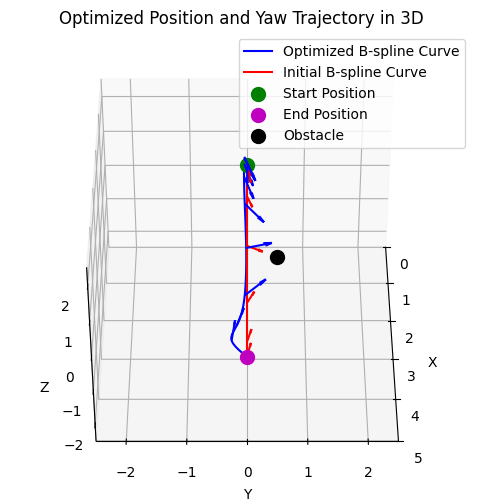

In [291]:
optimized_x_values, optimized_y_values, optimized_z_values, optimized_quivers = get_bspline_3d(clamped_optimized_pos_control_points, clamped_optimized_yaw_control_points, clamped_knots_pos, clamped_knots_yaw, p, obstacle_position, 'Optimized B-spline Curve')
initial_x_values, initial_y_values, initial_z_values, initial_quivers = get_bspline_3d(clamped_initial_pos_control_points, clamped_initial_yaw_control_points, clamped_knots_pos, clamped_knots_yaw, p, obstacle_position, 'Initial B-spline Curve', use_optimized_curve=False)

# Plot the B-spline in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot control points
# ax.plot(control_points[:, 0], control_points[:, 1], control_points[:, 2], 'bo-', label='Control Points')

# Plot the B-spline curve
ax.plot(optimized_x_values, optimized_y_values, optimized_z_values, 'b-', label='Optimized B-spline Curve')
ax.plot(initial_x_values, initial_y_values, initial_z_values, 'r-', label='Initial B-spline Curve')

# Plot the start and end points
ax.scatter(start_position[0], start_position[1], start_position[2], color='g', s=100, label='Start Position')
ax.scatter(end_position[0], end_position[1], end_position[2], color='m', s=100, label='End Position')

# Plot the obstacle
ax.scatter(obstacle_position[0], obstacle_position[1], obstacle_position[2], color='k', s=100, label='Obstacle')

# Plot attitude vectors
for i in range(len(optimized_quivers)):
    pos_at_t, attitude_vector = optimized_quivers[i]
    ax.quiver(pos_at_t[0], pos_at_t[1], pos_at_t[2], attitude_vector[0], attitude_vector[1], attitude_vector[2], color='b', length=0.5, normalize=True)
for i in range(len(initial_quivers)):
    pos_at_t, attitude_vector = initial_quivers[i]
    ax.quiver(pos_at_t[0], pos_at_t[1], pos_at_t[2], attitude_vector[0], attitude_vector[1], attitude_vector[2], color='r', length=0.3, normalize=True)

# Set labels, title, and show the plot
ax.set_title("Optimized Position and Yaw Trajectory in 3D")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Set axes sizes for better visualization
ax.set_xlim([0, 5])
ax.set_ylim([-2.5, 2.5])
ax.set_zlim([-2.5, 2.5])

# Set view angle for better visualization
ax.view_init(elev=40, azim=0)

plt.show()